<a href="https://colab.research.google.com/github/mrozikk/Data-Science-For-Beginners/blob/main/ProjektKo%C5%84cowy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analiza sentymentu  na danych pobranych z  Amazon, Yelp i Imdb 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Pobranie i eksploracja danych

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import nltk
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import string
from __future__ import division
from textblob import TextBlob
import math

In [4]:
filepath_dict = {'yelp':   'yelp_labelled.txt',
                 'amazon': 'amazon_cells_labelled.txt',
                 'imdb':   'imdb_labelled.txt'}


In [5]:
df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)
    print(df_list)

[                                              sentence  label source
0                             Wow... Loved this place.      1   yelp
1                                   Crust is not good.      0   yelp
2            Not tasty and the texture was just nasty.      0   yelp
3    Stopped by during the late May bank holiday of...      1   yelp
4    The selection on the menu was great and so wer...      1   yelp
..                                                 ...    ...    ...
995  I think food should have flavor and texture an...      0   yelp
996                           Appetite instantly gone.      0   yelp
997  Overall I was not impressed and would not go b...      0   yelp
998  The whole experience was underwhelming, and I ...      0   yelp
999  Then, as if I hadn't wasted enough of my life ...      0   yelp

[1000 rows x 3 columns]]
[                                              sentence  label source
0                             Wow... Loved this place.      1   yelp
1     

In [6]:
df = pd.concat(df_list)
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 747
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  2748 non-null   object
 1   label     2748 non-null   int64 
 2   source    2748 non-null   object
dtypes: int64(1), object(2)
memory usage: 85.9+ KB


#sprawdzenie zbilansowania danych

In [8]:
df['label'].value_counts()

1    1386
0    1362
Name: label, dtype: int64

In [9]:
neg1_files = df[df["label"] == 0]
neg_files = neg1_files['sentence'][0:1000]
val_neg_files = neg1_files['sentence'][1001:1300]
neg_files.to_csv('aclImdb/train/neg/neg.txt')
val_neg_files.to_csv('aclImdb/val/neg/neg.txt')
 


In [10]:
pos1_files = df[df["label"] == 1]
pos_files = pos1_files['sentence'][0:1000]
val_pos_files = pos1_files['sentence'][1001:1300]
pos_files.to_csv('aclImdb/train/pos/pos.txt')
val_pos_files.to_csv('aclImdb/val/pos/pos.txt')

##Czyszczenie danych

In [11]:
stemmer = nltk.SnowballStemmer("english")

from nltk.corpus import stopwords
nltk.download('stopwords')

stopword = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def clean(dane):
  dane = str(dane).lower()
  dane = re.sub('\[.*?\]', '', dane)
  dane = re.sub('https?://\S+|www\.\S+', '', dane)
  dane = re.sub('<.*?>+', '', dane)
  dane = re.sub('[%s]' % re.escape(string.punctuation), '', dane)
  dane = re.sub('\n', '', dane)
  dane = re.sub('\w*\d\w*', '', dane)
  dane = [word for word in dane.split(' ') if word not in stopword]
  dane = " ".join(dane)
  dane = [stemmer.stem(word) for word in dane.split(' ')]
  dane = " ".join(dane)
  return dane

df['sentence'] = df['sentence'].apply(clean)


sentence=" ".join(i for i in df.sentence)
pos_sent=" ".join(i for i in pos_files)
neg_sent=" ".join(i for i in neg_files)

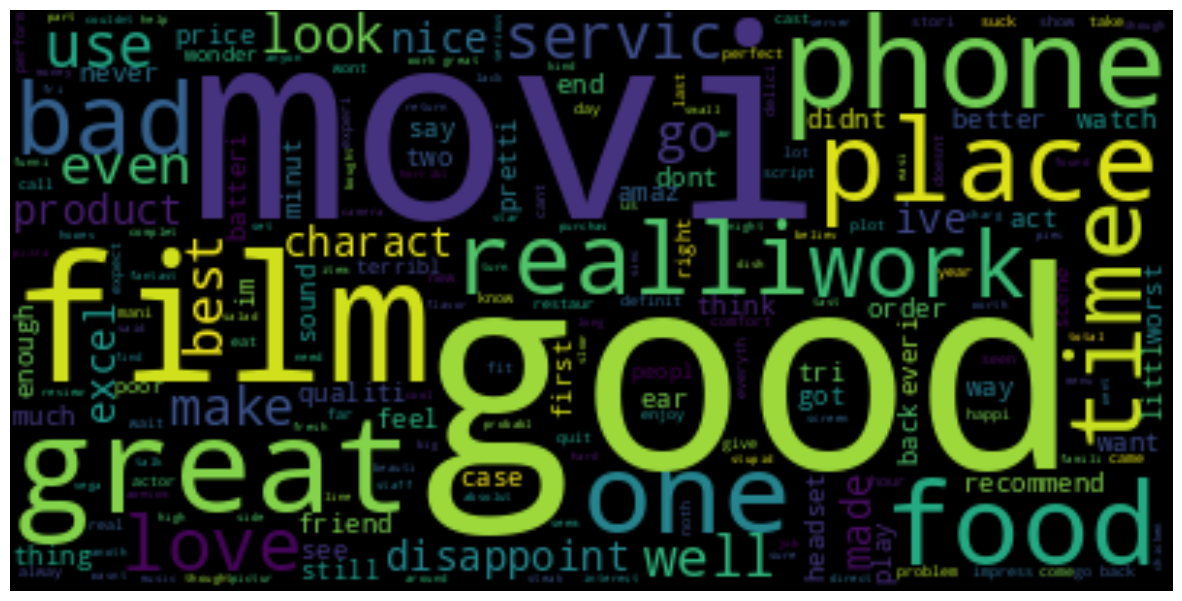

In [13]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color="black").generate(sentence)   

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

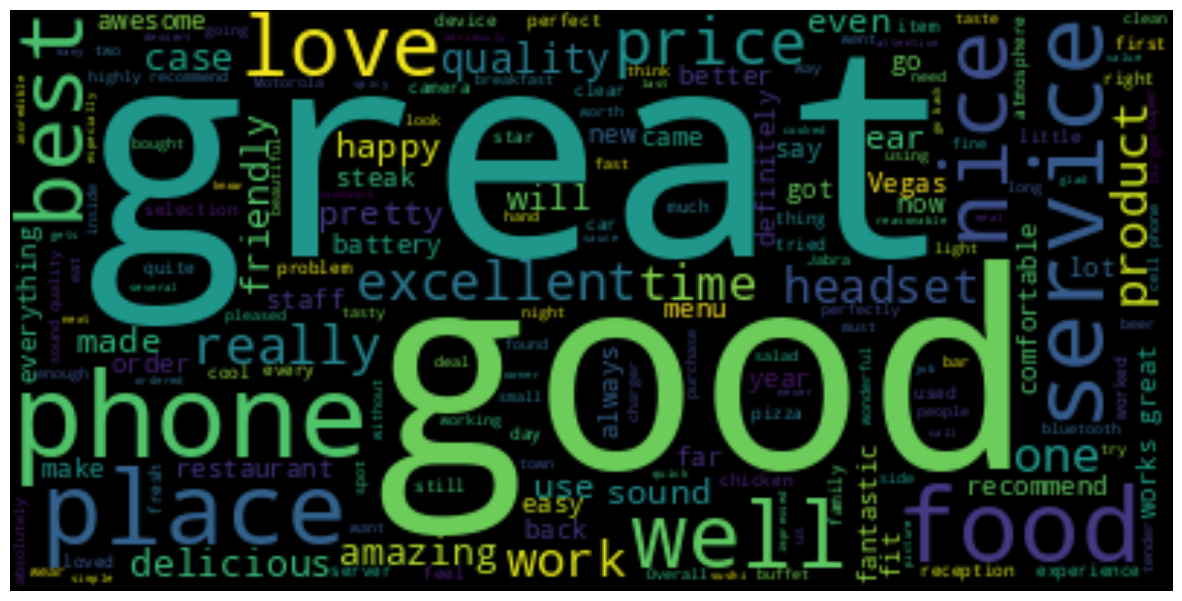

In [14]:
#pozytywne słowa
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color="black").generate(pos_sent)   

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

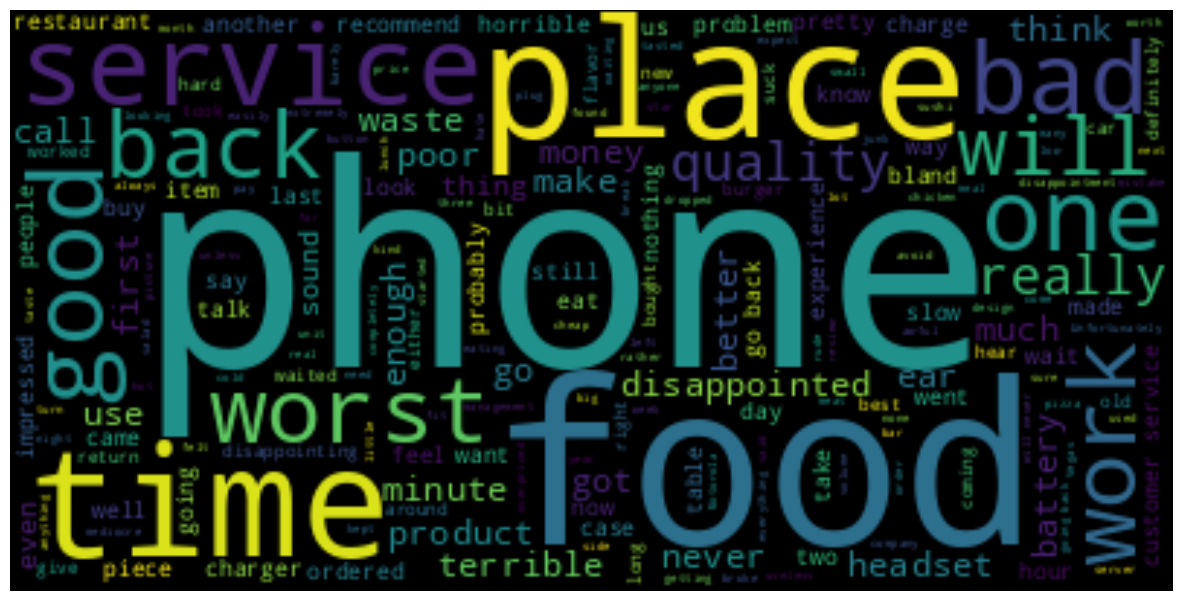

In [15]:
#negatywne
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,background_color="black").generate(neg_sent)   

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Podział danych na zbiór treningowy i testowy


In [16]:
X=df['sentence']
y=df['label']

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.3, random_state=23)

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)
CountVectorizer()

CountVectorizer()

In [19]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = vect.transform(X_train)
X_test_dtm = vect.transform(X_valid)

In [20]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=200)

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(X_train_dtm)
X_train_tfidf = tfidf_transformer.transform(X_train_dtm)

X_train_tfidf

<1923x3378 sparse matrix of type '<class 'numpy.float64'>'
	with 12460 stored elements in Compressed Sparse Row format>

In [26]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(X_train_dtm, y_train)

MultinomialNB()

In [27]:
# Make class anf probability predictions
y_pred_class = nb.predict(X_test_dtm)
y_pred_prob = nb.predict_proba(X_test_dtm)



In [28]:
# calculate accuracy of class predictions
from sklearn.metrics import confusion_matrix
print(accuracy_score(y_valid, y_pred_class))



0.7915151515151515


In [29]:
!pip install transformers
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize



import torch
from torch.utils.data import Dataset, DataLoader


  

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [70]:


def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)
     


In [71]:
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    self.hparams = hparams
    
    self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)
  
  def is_logger(self):
    return self.trainer.proc_rank <= 0
  
  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask,
        lm_labels=lm_labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        lm_labels=lm_labels,
        decoder_attention_mask=batch['target_mask']
    )

    loss = outputs[0]

    return loss

  def training_step(self, batch, batch_idx):
    loss = self._step(batch)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}
  
  def training_epoch_end(self, outputs):
    avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}
    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
    return {"val_loss": loss}
  
  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}
    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparams.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
    self.opt = optimizer
    return [optimizer]
  
  def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
    if self.trainer.use_tpu:
      xm.optimizer_step(optimizer)
    else:
      optimizer.step()
    optimizer.zero_grad()
    self.lr_scheduler.step()
  
  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparams)
    dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
    t_total = (
        (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
        // self.hparams.gradient_accumulation_steps
        * float(self.hparams.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparams)
    return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)

In [72]:
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))
     

In [73]:
args_dict = dict(
    data_dir="aclImdb/train", # path for data files
    output_dir="aclImdb/val", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length=512,
    learning_rate=3e-4,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=16,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)
     

In [ ]:
train_pos_files = glob.glob('aclImdb/train/pos/pos.txt')
train_neg_files = glob.glob('aclImdb/train/neg/neg.txt')
  

len(train_pos_files), len(train_neg_files)

In [ ]:
!pip install sentencepiece
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [ ]:
ids_neg = tokenizer.encode('negative ')
ids_pos = tokenizer.encode('positive ')
len(ids_neg), len(ids_pos)
     

In [ ]:
class ImdbDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.pos_file_path = os.path.join(data_dir, type_path, 'pos')
    self.neg_file_path = os.path.join(data_dir, type_path, 'neg')
    
    self.pos_files = glob.glob("%s/*.txt" % self.pos_file_path)
    self.neg_files = glob.glob("%s/*.txt" % self.neg_file_path)
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []

    self._build()
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
  
  def _build(self):
    self._buil_examples_from_files(self.pos_files, 'positive')
    self._buil_examples_from_files(self.neg_files, 'negative')
  
  def _buil_examples_from_files(self, files, sentiment):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()]")
    REPLACE_WITH_SPACE = re.compile("()|(\-)|(\/)")

    for path in files:
      with open(path, 'r') as f:
        text = f.read()
      
      line = text.strip()
      line = REPLACE_NO_SPACE.sub("", line) 
      line = REPLACE_WITH_SPACE.sub("", line)
      line = line + ' '

      target = sentiment + " "

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [line], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=2, pad_to_max_length=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)
     


In [ ]:
dataset = ImdbDataset(tokenizer, '/content/aclImdb/', 'val',  max_len=512)
len(dataset)

In [ ]:
data = dataset[0]
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids']))

In [ ]:
!mkdir -p t5_imdb_sentiment

In [ ]:
args_dict.update({'data_dir': 'aclImdb', 'output_dir': 't5_imdb_sentiment', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)

#checkpoint_callback = pl.callbacks.ModelCheckpoint(
    #dirpath=args.output_dir, monitor="val_loss", mode="min", save_top_k=5
#)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    max_epochs=args.num_train_epochs,
    precision= 16 if args.fp_16 else 32,
    gradient_clip_val=args.max_grad_norm,
    #checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)
     

In [ ]:
def get_dataset(tokenizer, type_path, args):
  return ImdbDataset(tokenizer=tokenizer, data_dir=args.data_dir, type_path=type_path,  max_len=args.max_seq_length)

In [ ]:
model = T5Tokenizer.from_pretrained('t5-base')

In [ ]:
trainer = pl.Trainer(**train_params)

In [ ]:
trainer.fit(model) 

In [ ]:
!mkdir t5_base_imdb_sentiment

In [ ]:


import textwrap
from tqdm.auto import tqdm
from sklearn import metrics
     


In [ ]:


dataset = ImdbDataset(tokenizer, 'aclImdb', 'test',  max_len=512)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
     


In [ ]:


it = iter(loader)
     


In [ ]:


batch = next(it)
batch["source_ids"].shape
     


In [ ]:
outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

dec = [tokenizer.decode(ids) for ids in outs]

texts = [tokenizer.decode(ids) for ids in batch['source_ids']]
targets = [tokenizer.decode(ids) for ids in batch['target_ids']]
     

In [ ]:
for i in range(32):
    lines = textwrap.wrap("Review:\n%s\n" % texts[i], width=100)
    print("\n".join(lines))
    print("\nActual sentiment: %s" % targets[i])
    print("Predicted sentiment: %s" % dec[i])
    print("=====================================================================\n")

In [ ]:
loader = DataLoader(dataset, batch_size=32, num_workers=4)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'].cuda(), 
                              attention_mask=batch['source_mask'].cuda(), 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [ ]:
for i, out in enumerate(outputs):
  if out not in ['positive', 'negative']:
    print(i, 'detected invalid prediction')
     

In [ ]:


metrics.accuracy_score(targets, outputs)
     


In [ ]:


print(metrics.classification_report(targets, outputs))
     


Data Transformation

The T5 model does not work with raw text. Instead, it requires the text to be transformed into numerical form in order to perform training and inference. The following transformations are required for the T5 model:

    Tokenize text

    Convert tokens into (integer) IDs

    Truncate the sequences to a specified maximum length

    Add end-of-sequence (EOS) and padding token IDs

T5 uses a SentencePiece model for text tokenization. Below, we use a pre-trained SentencePiece model to build the text pre-processing pipeline using torchtext’s T5Transform. Note that the transform supports both batched and non-batched text input (for example, one can either pass a single sentence or a list of sentences), however the T5 model expects the input to be batched.

In [30]:
!pip install simplet5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
model = simpleT5()

NameError: ignored

In [38]:
df.head()

,sentence,label,source
0,wow love place,1,yelp
1,crust good,0,yelp
2,tasti textur nasti,0,yelp
3,stop late may bank holiday rick steve recommen...,1,yelp
4,select menu great price,1,yelp


In [53]:
df2=df

In [64]:


!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
#f2['label']#1-positive, 0-negative


df2[df2['label'] == 1] = 'positive'
#df2.loc['label':'1', ['label']] = 'positive'

df2



KeyError: ignored